# PetIBM: strong-scaling analysis on Colonial One

---

In [1]:
import logSummaryReader # collection of classes and functions to parse given PETSc log summary files
%matplotlib inline

In [2]:
root_directory = '/home/mesnardo/simulations_PetIBM/scalability/strong_scaling_colonialone'

---

## Objective

Perform a strong-scaling analysis of [PetIBM](https://github.com/barbagroup/PetIBM) (a PETSc-based Immersed Boundary Method code) on the GWU cluster, [Colonial One](http://ots.columbian.gwu.edu/colonial-one-high-performance-computing-initiative), using PETSc-3.5.2 with various MPI libraries.

List of MPI libraries tested:
* /cm/shared/apps/mpich2/ge/gcc/64/1.4.1p1
* /c1/apps/openmpi/gcc/64/1.8
* /c1/apps/openmpi/1.8/gcc/4.9.2
* /c1/apps/mpich/3.1.4

PetIBM solves the incompressible Navier-Stokes equations using the Immersed Boundary Method from Taira and Colonius [2007](http://colonius.caltech.edu/pdfs/TairaColonius2007.pdf). The main steps of the implementation are:
* set the RHS for the velocity system (name of event: `RHSVelocity`)
* solve the velocity system (`solveVelocity`)
* set the RHS for the Poisson-like system (`RHSPoisson`)
* solve the Poisson-like system for the grou {pressure+force} (`solvePoisson`)
* project the velocity onto the divergence-free subspace (`projectionStep`)

The test-case chosen is the three-dimensional lid-driven cavity flow, using two meshes: 1 million cells ($100\times 100\times 100$) and 8 millions cells ($200\times 200\times 200$).

We use (for the purpose of the strong scaling analysis) the Congugate Gradient method without preoconditioner to solve both systems.

By choosing the mesh-size, the mpi implementation and the PETSc solvers, we define a series.

For each series, the simulation was repeated using a different number of processes (from 1 to 128, multiples of 2).
Each series was repeated three times.

The next section gives a detail on how the PetIBM executables were created.

---

##  Building PETSc-3.5.2 using various MPI implementations

* export PETSC_DIR=/home/mesnardo/src/petsc/3.5.2
* building with various implementations of MPI
* building in debugging and/or optimized mode
* including blas and lapack libs:
    * blas: /c1/apps/blas/gcc/1/libblas.a
    * lapack: /c1/apps/lapack/gc/3.4.1/lib/lilapack.a

* /cm/shared/apps/mpich2/ge/gcc/64/1.4.1p1
    * debugging mode
```bash
module load mpich2/ge/gcc
export PETSC_DIR=/home/mesnardo/src/petsc/3.5.2
export PETSC_ARCH=linux-mpich2-gnu-dbg
./configure --PETSC_ARCH=$PETSC_ARCH \
--with-mpi-dir=/cm/shared/apps/mpich2/ge/gcc/64/1.4.1p1/bin \
--with-blas-lib=/c1/apps/blas/gcc/1/lib64/libblas.a \
--with-lapack-lib=/c1/apps/lapack/gcc/3.4.1/lib/liblapack.a \
--with-shared-libraries=0
make all
make test
```
    * optimized mode
```bash
module load mpich2/ge/gcc
export PETSC_DIR=/home/mesnardo/src/petsc/3.5.2
export PETSC_ARCH=linux-mpich2-gnu-opt
./configure COPTFLAGS="-O3" CXXOPTFLAGS="-O3" FOPTFLAGS="-O3" \
--PETSC_ARCH=$PETSC_ARCH \
--with-debugging=0  \
--with-mpi-dir=/cm/shared/apps/mpich2/ge/gcc/64/1.4.1p1/bin \
--with-blas-lib=/c1/apps/blas/gcc/1/lib64/libblas.a \
--with-lapack-lib=/c1/apps/lapack/gcc/3.4.1/lib/liblapack.a \
--with-shared-libraries=0
make all
make test
```

* /c1/apps/openmpi/gcc/64/1.8
    * debugging mode
```bash
module load openmpi/gcc/64/1.8
export PETSC_DIR=/home/mesnardo/src/petsc/3.5.2
export PETSC_ARCH=linux-openmpi-gnu-dbg
./configure \
--PETSC_ARCH=$PETSC_ARCH \
--with-mpi-dir=/c1/apps/openmpi/gcc/64/1.8 \
--with-blas-lib=/c1/apps/blas/gcc/1/lib64/libblas.a \
--with-lapack-lib=/c1/apps/lapack/gcc/3.4.1/lib/liblapack.a \
--with-shared-libraries=0
make all
make test
```
    * optmized mode
```bash
module load openmpi/gcc/64/1.8
export PETSC_DIR=/home/mesnardo/src/petsc/3.5.2
export PETSC_ARCH=linux-openmpi-gnu-opt
./configure COPTFLAGS="-O3" CXXOPTFLAGS="-O3" FOPTFLAGS="-O3" \
--PETSC_ARCH=$PETSC_ARCH \
--with-debugging=0 \
--with-mpi-dir=/c1/apps/openmpi/gcc/64/1.8 \
--with-blas-lib=/c1/apps/blas/gcc/1/lib64/libblas.a \
--with-lapack-lib=/c1/apps/lapack/gcc/3.4.1/lib/liblapack.a \
--with-shared-libraries=0
make all
make test
```

* /c1/apps/openmpi/1.8/gcc/4.9.2
    * optmized mode
```bash
module load openmpi/1.8/gcc/4.9.2
export PETSC_DIR=/home/mesnardo/src/petsc/3.5.2
export PETSC_ARCH=linux-openmpi-1.8-gcc-4.9.2-opt
./configure COPTFLAGS="-O3" CXXOPTFLAGS="-O3" FOPTFLAGS="-O3" \
--PETSC_ARCH=$PETSC_ARCH \
--with-debugging=0 \
--with-mpi-dir=/c1/apps/openmpi/1.8/gcc/4.9.2 \
--with-blas-lib=/c1/apps/blas/gcc/1/lib64/libblas.a \
--with-lapack-lib=/c1/apps/lapack/gcc/3.4.1/lib/liblapack.a \
--with-shared-libraries=0
make all
make test
```

* /c1/apps/mpich/3.1.4
    * optimized mode
```bash
module load mpich/3.1.4
export PETSC_DIR=/home/mesnardo/src/petsc/3.5.2
export PETSC_ARCH=linux-mpich-3.1.4-gnu-opt
./configure COPTFLAGS="-O3" CXXOPTFLAGS="-O3" FOPTFLAGS="-O3" \
--PETSC_ARCH=$PETSC_ARCH \
--with-debugging=0 \
--with-mpi-dir=/c1/apps/mpich/3.1.4 \
--with-blas-lib=/c1/apps/blas/gcc/1/lib64/libblas.a \
--with-lapack-lib=/c1/apps/lapack/gcc/3.4.1/lib/liblapack.a \
--with-shared-libraries=0
make all
make test
```

---

## Building PetIBM

```bash
export PETSC_DIR=/home/mesnardo/src/petsc/3.5.2
export PETSC_ARCH='the one you want'
export PETIBM_DIR=/home/mesnardo/src/PetIBM
cd $PETIBM_DIR
make
```

---

## PetIBM executable provided by Glen

Looking at the logging files generated by simulations run with the PetIBM executable provided by Glen, the PETSc/PetIBM configuration is the following:

* PETSc-3.5.2: directory: /home/maclach/source/petsc-3.5.2
* $PETSC_ARCH = arch-linux2-debug (i.e. was compiled with debugging mode, so expecting runs to be about 4 times slower than with optimized mode)
* MPI: /c1/apps/openmpi/1.8/gcc/4.9.2
* LAPACK library: /c1/apps/lapack/gcc/3.4.1/lib/libflapack.a
* BLAS library: /c1/apps/blas/gcc/1/lib64/libfblas.a

---

## Profiling simulation using -log_summary

For each simulation, the log file has been generated by adding the PETSc command-line argument:

`-log_summary`

It prints an ASCII version of performance data at the end of the program execution.

For each PETSc routine, the output data include the maximum time and floating point operation rate over all processes (note: memory loads and stores are the real performance barrier, not flop rates).

The summary for each phase presents the maximum times and flop rates over all processes, as well as the ratio of maximum times and flop rates for all processes. A ratio of approximately 1 indicates that computations within a given phase are well balances among the processes; as the ratio increases, the balance becomes increasingly poor.

The Python cells of this notebook parse the different log summary files and plot performance data of the different events of a PetIBM run.

---

## Test-case: 3d lid-driven cavity flow (1M-cell, 100x100x100)

---

### /cm/shared/apps/mpich2/ge/gcc/64/1.4.1p1

In [3]:
# cavity (1M cells) - mpich2 - parse log files
mpi = 'mpich2'
simulation = 'cavity3d/100x100x100'
runs = ['cg_nopc_cg_nopc_run1', 
        'cg_nopc_cg_nopc_run2', 
        'cg_nopc_cg_nopc_run3']
nprocs = [1, 2, 4, 8, 16, 32, 64, 128]
mpich2_1m_list = []
for run in runs:
    directory = '{}/{}/{}/{}'.format(root_directory, mpi, simulation, run)
    mpich2_1m_list.append(logSummaryReader.Series(directory, nprocs=nprocs))

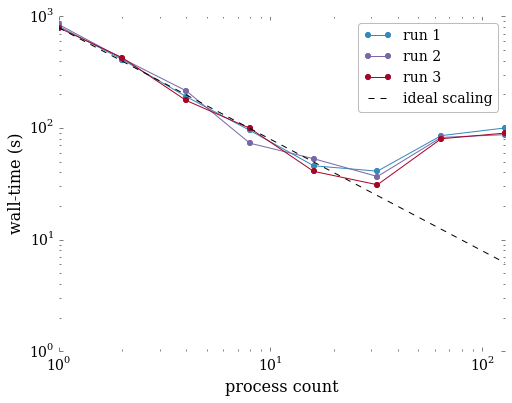

In [4]:
# cavity (1M cells) - mpich2 - execution-time
logSummaryReader.plot_execution_time(mpich2_1m_list)

### /c1/apps/openmpi/gcc/64/1.8

In [5]:
# cavity (1M cells) - openmpi18 - parse log files
mpi = 'openmpi'
simulation = 'cavity3d/100x100x100'
runs = ['cg_nopc_cg_nopc_run1', 
        'cg_nopc_cg_nopc_run2', 
        'cg_nopc_cg_nopc_run3']
nprocs = [1, 2, 4, 8, 16, 32, 64, 128]
openmpi18_1m_list = []
for run in runs:
    directory = '{}/{}/{}/{}'.format(root_directory, mpi, simulation, run)
    openmpi18_1m_list.append(logSummaryReader.Series(directory, nprocs=nprocs))

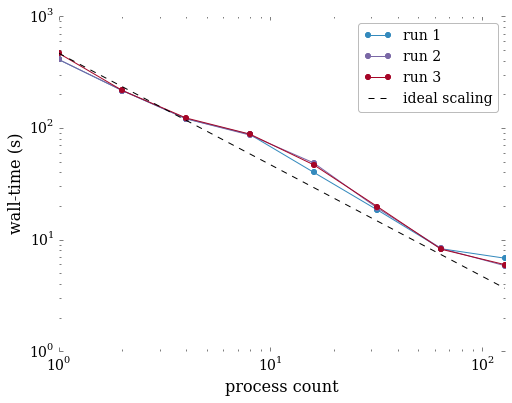

In [6]:
# cavity (1M cells) - openmpi18 - execution-time
logSummaryReader.plot_execution_time(openmpi18_1m_list)

### PetIBM executable provided by Glen

In [7]:
# cavity (1M cells) - maclach - parse log files
mpi = 'maclach'
simulation = 'cavity3d/100x100x100'
runs = ['cg_nopc_cg_nopc_run1', 
        'cg_nopc_cg_nopc_run2', 
        'cg_nopc_cg_nopc_run3']
nprocs = [1, 2, 4, 8, 16, 32, 64, 128]
maclach_1m_list = []
for run in runs:
    directory = '{}/{}/{}/{}'.format(root_directory, mpi, simulation, run)
    maclach_1m_list.append(logSummaryReader.Series(directory, nprocs=nprocs))

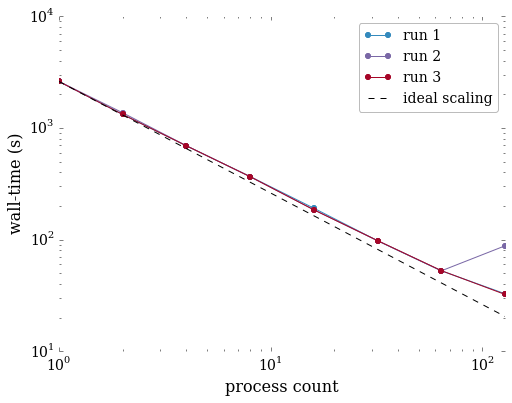

In [8]:
# cavity (1M cells) - maclach - execution-time
logSummaryReader.plot_execution_time(maclach_1m_list)

### /c1/apps/openmpi/1.8/gcc/4.9.2/cpu

In [9]:
# cavity (1M cells) - openmpi18_492 - parse log files
mpi = 'openmpi-1.8-gcc-4.9.2-opt'
simulation = 'cavity3d/100x100x100'
runs = ['cg_nopc_cg_nopc_run1', 
        'cg_nopc_cg_nopc_run2']
nprocs = [1, 2, 4, 8, 16, 32, 64, 128]
openmpi18_492_1m_list = []
for run in runs:
    directory = '{}/{}/{}/{}'.format(root_directory, mpi, simulation, run)
    openmpi18_492_1m_list.append(logSummaryReader.Series(directory, nprocs=nprocs))

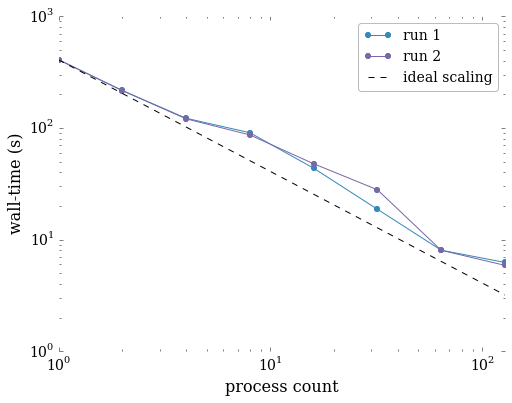

In [10]:
# cavity (1M cells) - openmpi18_492 - execution-time
logSummaryReader.plot_execution_time(openmpi18_492_1m_list)

### /c1/apps/mpich/3.1.4

In [11]:
# cavity (1M cells) - mpich314 - parse log files
mpi = 'mpich-3.1.4-gnu-opt'
simulation = 'cavity3d/100x100x100'
runs = ['cg_nopc_cg_nopc_run1', 
        'cg_nopc_cg_nopc_run2', 
        'cg_nopc_cg_nopc_run3']
nprocs = [1, 2, 4, 8, 16, 32, 64, 128]
mpich314_1m_list = []
for run in runs:
    directory = '{}/{}/{}/{}'.format(root_directory, mpi, simulation, run)
    mpich314_1m_list.append(logSummaryReader.Series(directory, nprocs=nprocs))

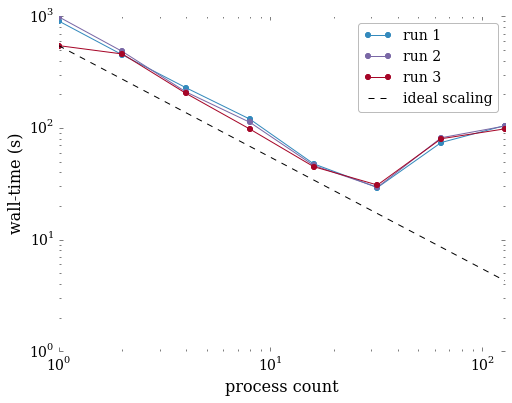

In [12]:
# cavity (1M cells) - mpich314 - execution-time
logSummaryReader.plot_execution_time(mpich314_1m_list)

---

## Test-case: 3d lid-driven cavity flow (8M-cell, 200x200x200)

---

### /cm/shared/apps/mpich2/ge/gcc/64/1.4.1p1

In [13]:
# cavity (8M cells) - mpich2 - parse log files
mpi = 'mpich2'
simulation = 'cavity3d/200x200x200'
runs = ['cg_nopc_cg_nopc_run1', 
        'cg_nopc_cg_nopc_run2', 
        'cg_nopc_cg_nopc_run3']
nprocs = [1, 2, 4, 8, 16, 32, 64, 128]
mpich2_8m_list = []
for run in runs:
    directory = '{}/{}/{}/{}'.format(root_directory, mpi, simulation, run)
    mpich2_8m_list.append(logSummaryReader.Series(directory, nprocs=nprocs))

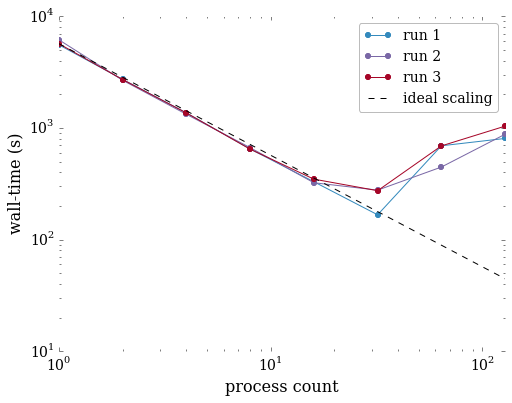

In [14]:
# cavity (8M cells) - mpich2 - execution-time
logSummaryReader.plot_execution_time(mpich2_8m_list)

### /c1/apps/openmpi/gcc/64/1.8

In [15]:
# cavity (8M cells) - openmpi18 - parse log files
mpi = 'openmpi'
simulation = 'cavity3d/200x200x200'
runs = ['cg_nopc_cg_nopc_run1', 
        'cg_nopc_cg_nopc_run2', 
        'cg_nopc_cg_nopc_run3']
nprocs = [1, 2, 4, 8, 16, 32, 64, 128]
openmpi18_8m_list = []
for run in runs:
    directory = '{}/{}/{}/{}'.format(root_directory, mpi, simulation, run)
    openmpi18_8m_list.append(logSummaryReader.Series(directory, nprocs=nprocs))

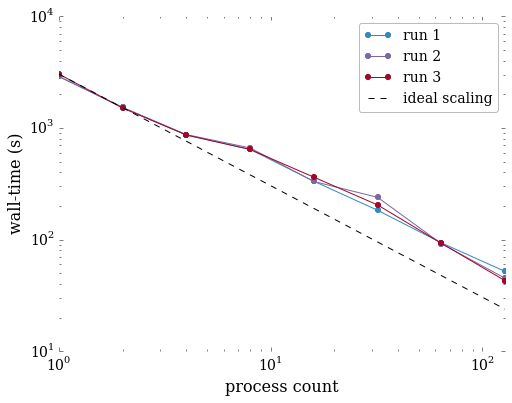

In [16]:
# cavity (8M cells) - openmpi18 - execution-time
logSummaryReader.plot_execution_time(openmpi18_8m_list)

### PetIBM executable provided by Glen

In [17]:
# cavity (8M cells) - maclach - parse log files
mpi = 'maclach'
simulation = 'cavity3d/200x200x200'
runs = ['cg_nopc_cg_nopc_run1', 
        'cg_nopc_cg_nopc_run2', 
        'cg_nopc_cg_nopc_run3']
nprocs = [1, 2, 4, 8, 16, 32, 64, 128]
maclach_8m_list = []
for run in runs:
    directory = '{}/{}/{}/{}'.format(root_directory, mpi, simulation, run)
    maclach_8m_list.append(logSummaryReader.Series(directory, nprocs=nprocs))

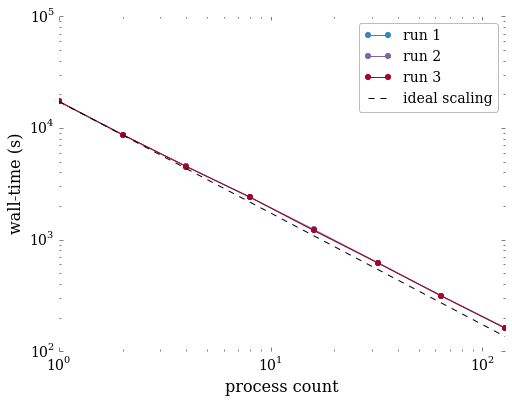

In [18]:
# cavity (8M cells) - maclach - execution-time
logSummaryReader.plot_execution_time(maclach_8m_list)

### /c1/apps/openmpi/1.8/gcc/4.9.2/cpu

In [19]:
# cavity (8M cells) - openmpi18_492 - parse log files
mpi = 'openmpi-1.8-gcc-4.9.2-opt'
simulation = 'cavity3d/200x200x200'
runs = ['cg_nopc_cg_nopc_run1', 
        'cg_nopc_cg_nopc_run2', 
        'cg_nopc_cg_nopc_run3']
nprocs = [1, 2, 4, 8, 16, 32, 64, 128]
openmpi18_492_8m_list = []
for run in runs:
    directory = '{}/{}/{}/{}'.format(root_directory, mpi, simulation, run)
    openmpi18_492_8m_list.append(logSummaryReader.Series(directory, nprocs=nprocs))

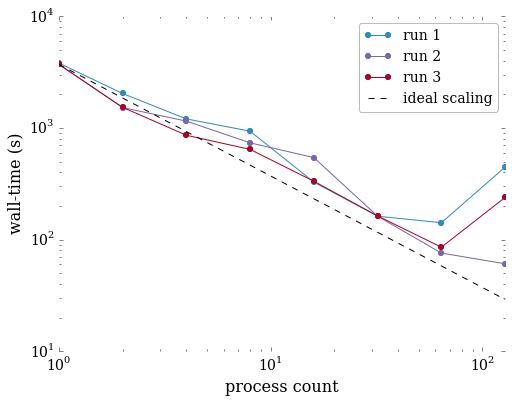

In [20]:
# cavity (8M cells) - openmpi18_492 - execution-time
logSummaryReader.plot_execution_time(openmpi18_492_8m_list)

### /c1/apps/mpich/3.1.4

In [21]:
# cavity (8M cells) - mpich314 - parse log files
mpi = 'mpich-3.1.4-gnu-opt'
simulation = 'cavity3d/200x200x200'
runs = ['cg_nopc_cg_nopc_run1', 
        'cg_nopc_cg_nopc_run2', 
        'cg_nopc_cg_nopc_run3']
nprocs = [1, 2, 4, 8, 16, 32, 64, 128]
mpich314_8m_list = []
for run in runs:
    directory = '{}/{}/{}/{}'.format(root_directory, mpi, simulation, run)
    mpich314_8m_list.append(logSummaryReader.Series(directory, nprocs=nprocs))

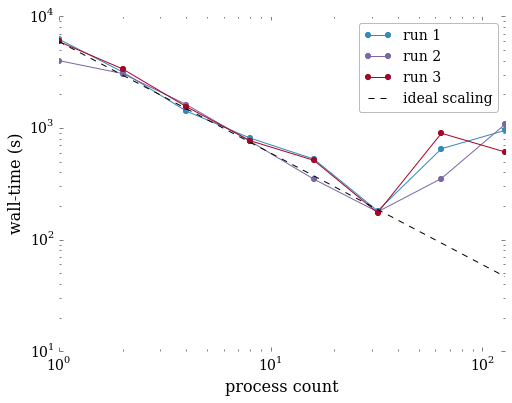

In [22]:
# cavity (8M cells) - mpich314 - execution-time
logSummaryReader.plot_execution_time(mpich314_8m_list)

### Analyzing events of runs with mpich-3.1.4 on 8M-cell mesh

#### $\bullet$ event: solvePoisson

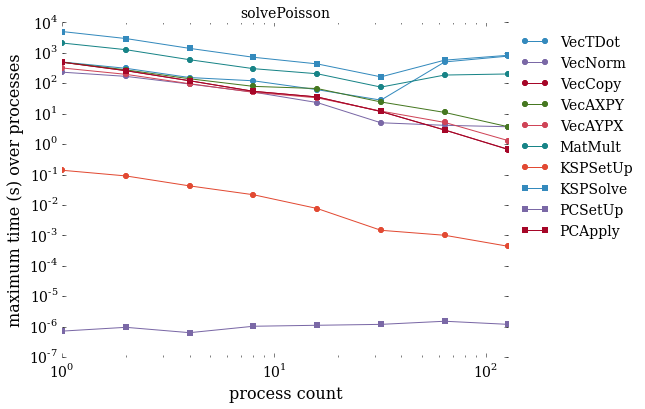

In [23]:
logSummaryReader.plot_phases_event_average(mpich314_8m_list, 'solvePoisson', 'max_time', 
                                           ylabel='maximum time (s) over processes')

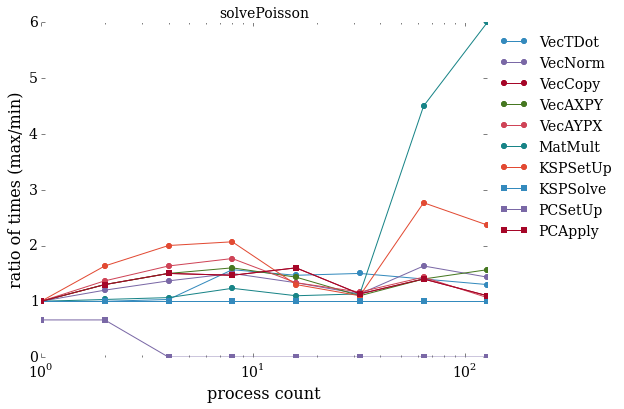

In [24]:
logSummaryReader.plot_phases_event_average(mpich314_8m_list, 'solvePoisson', 'ratio_time',
                                           ylabel='ratio of times (max/min)')

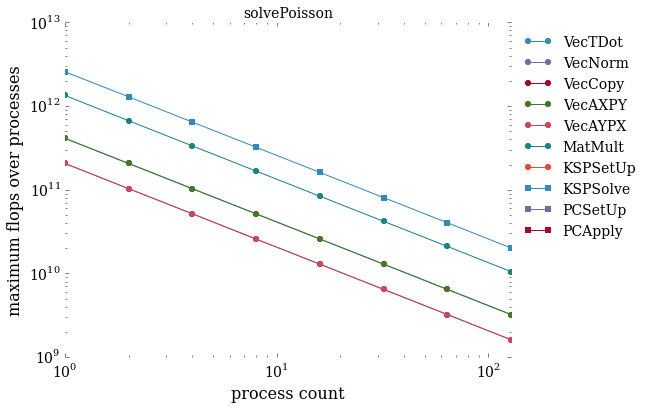

In [25]:
logSummaryReader.plot_phases_event_average(mpich314_8m_list, 'solvePoisson', 'max_flops', 
                                           ylabel='maximum flops over processes')

#### $\bullet$ event: solveVelocity

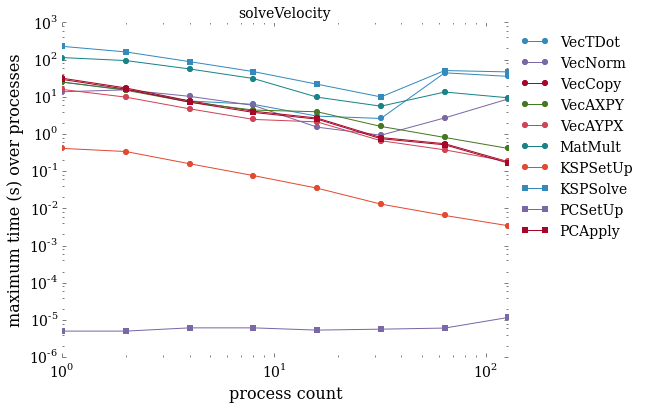

In [26]:
logSummaryReader.plot_phases_event_average(mpich314_8m_list, 'solveVelocity', 'max_time', 
                                           ylabel='maximum time (s) over processes')

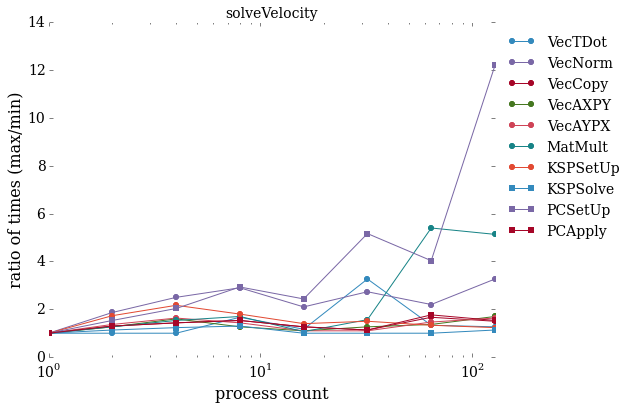

In [27]:
logSummaryReader.plot_phases_event_average(mpich314_8m_list, 'solveVelocity', 'ratio_time', 
                                           ylabel='ratio of times (max/min)')

---

---